In [1]:
from sqlalchemy import select
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.coordinates import (
    ICRS,
    GCRS,
    GeocentricTrueEcliptic,
    HeliocentricTrueEcliptic,
    solar_system_ephemeris,
    EarthLocation,
    angular_separation
)
from astropy.time import Time
import astropy.units as u

from models import session, TanWcs, RectangularCoords, RectangularHeliocentricCoords, rect2sphere

%matplotlib inline

# Motivation

Notebook `01_region_select_example` demonstrates how, generally, raes on the sky can be selected. 

Let's assume the observation happened from an observatory on Earth (as opposed to space observatories). That observatory took a picture of the sky at `t1`. Observatory's coordinates and height above the sea are also known.

Then the image was then processed. Objects in the image were matched with known objects from catalogs. Now we know the `(x,y)` image coordinates of objects with known on-sky coordinates. This is used to determine the on-sky coordinates of the reference pixel in the image. 

Because the reference stars are so far, they ideally would not exhibit a measurable parallax (an apparent change in position) if observed from Earth or the Sun. Therefore their coordinates would remain the same whether we observed them from the Sun or the Earth. 

However, if there was an object in our image, that was not as far as the stars are - we would see that object shift. Because all pixel in the image were assigned coordinates using stars that have no parallax, they would assign our closer object - the "wrong" coordinates. The object would project to different coordinates based on how far it was from Earth during the time of observation. The further away it was, the less that parallax would be, when shifting Earth-Sun origins. This is the parallax that is implicitly applied in the described procedure measuring the center pixel on-sky coordinates. 

This is also what we want to correct for. Given an ICRS coordinates `(ra, dec)` we want to return a new ICRS coordinate `(ra', dec')` corrected for the parallax.

Here is an example, working backwards, that demonstrates how the object apparently shifts its position when it's distance is known versus assumed to be on a unit-sphere.

In [2]:
t = Time(59945.0, format="mjd", scale="utc")
ra = 10*u.deg
dec = 10*u.deg
distance = 50*u.AU

In [3]:
# example 1
ex1 = ICRS(
    ra=ra,
    dec=dec,
).transform_to(GeocentricTrueEcliptic(
    obstime=t,
))

ex1

<GeocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=59945.0): (lon, lat, distance) in (deg, deg, )
    (13.11222353, 5.23864674, 1.)>

In [4]:
# example 2 - including distance
ex2 = ICRS(
    ra=ra,
    dec=dec,
    distance=distance,
).transform_to(GeocentricTrueEcliptic(
    obstime=t
))

ex2

<GeocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=59945.0): (lon, lat, distance) in (deg, deg, AU)
    (11.97891514, 5.24217053, 49.96472122)>

In [5]:
# Example 2 seemingly includes parallax effects
ex2.transform_to(HeliocentricTrueEcliptic())

<HeliocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=J2000.000): (lon, lat, distance) in (deg, deg, AU)
    (13.11318343, 5.23709067, 50.00753423)>

Notice that without specifying distance a-priori, assumes, implicitly, some kind of distance. The value of the first example `distance` attribute is the value `1` of the type `Quantity`, i.e. it has no units. This is the indication that the coordinates are projected onto a unit-sphere in AstroPy, when distances are not known. 

# Setup

The following procedure is what I think the solution for the problem `(ra, dec)_noparallax + t_obs + d_guess --> (ra, dec, dist)` is. 


First we start by setting up some ground truth values so that we know what we have to expect on the other side. The following are all of our starting facts - including the assumed ground truth coordinates for our object.

In [6]:
# The targeted point in our solar system 
ra = 90*u.degree #90.0001149
dec = 23.43952556*u.degree
distance = 50*u.au #49.99939666

# Two observations where made, 6 months apart
t1 = Time("2023-03-20T16:00:00", format="isot", scale="utc")
t2 = Time("2023-09-24T04:00:00", format="isot", scale="utc")

# Made from CTIO observatory
with solar_system_ephemeris.set('de432s'):
    loc = EarthLocation.of_site('ctio')

In [7]:
# This is our ground-truth object in heliocentric and geocentric coordinates
helio = ICRS(ra, dec, distance=distance)
    
geo1 = helio.transform_to(
    GCRS(
        obstime=t1,
        obsgeoloc=(loc.x.value, loc.y.value, loc.z.value)*u.m
    )
)

geo2 = helio.transform_to(
    GCRS(
        obstime=t2,
        obsgeoloc=(loc.x.value, loc.y.value, loc.z.value)*u.m
    )
)

In [8]:
# This is what we would observe as the on-sky position of the object from
# Earth
geo_observed1 = GCRS(
    ra=geo1.ra,
    dec=geo1.dec,
    obstime=geo1.obstime,
    # but no assumed distance to object....
)

geo_observed2 = GCRS(
    ra=geo2.ra,
    dec=geo2.dec,
    obstime=geo2.obstime,
    # but no assumed distance to object....
)


# and, finally, this is what the reported position would be, if we transformed 
# the position we observed from the Earth, assuming a unit-sphere instead of a distance
# to the object.
icrs_observed1 = geo_observed1.transform_to(ICRS())
icrs_observed2 = geo_observed2.transform_to(ICRS())


print("Ground-truth ICRS for an object:")
print(helio)
print()

print("Observed GCRS for an object:")
print(geo1)
print(geo2)
print()

print("ICRS converted without any knowledge about the distance projects the ground truth to 'wrong' coordinates.")
print("These are the ICRS coordinates we start from:")
print(icrs_observed1)
print(icrs_observed2)

Ground-truth ICRS for an object:
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (90., 23.43952556, 50.)>

Observed GCRS for an object:
<GCRS Coordinate (obstime=2023-03-20T16:00:00.000, obsgeoloc=(1814303.74553723, -5214365.7436216, -3187340.56598756) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    (88.74517094, 23.4342652, 50.00135418)>
<GCRS Coordinate (obstime=2023-09-24T04:00:00.000, obsgeoloc=(1814303.74553723, -5214365.7436216, -3187340.56598756) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    (91.2426473, 23.43437408, 50.00265875)>

ICRS converted without any knowledge about the distance projects the ground truth to 'wrong' coordinates.
These are the ICRS coordinates we start from:
<ICRS Coordinate: (ra, dec) in deg
    (88.74513571, 23.43426475)>
<ICRS Coordinate: (ra, dec) in deg
    (91.24261107, 23.43437467)>


# 1. Proposed solution

Each image will have a different time-stamp - so they will all have different parallaxes even if the object was stationary. We start from an ICRS, timestamp location and a guess distance to the object. 

The way to do this is to:
* figure out what the observation coordinates are from Earth
* Add a distance to those coordinates
* Transform back to ICRS, including the parallax.

This, however, as it turns out is kind of not as easy to do as one would imagine. So presented are 4 different approaches to solving this issue. Some of them take in different set of values, but mostly it's the ICRS coordinate containing a parallax, a guess distance, the time and the location on Earth from which the observation was made.

They all return a "corrected for parallax" ICRS coordinate at two different time-stamps. The time stamps are expected to return the same "ground truth" ICRS coordinate, i.e. we are expecting the distances between all of the coordinates to be small. Both angular and 3D distances.

The reasons why this is expected are explained afterwards.

In [113]:
def correct_parallax1(icrs, obstime, point_on_earth, guess_distance):
    loca = (
        point_on_earth.x.to(u.m).value,
        point_on_earth.y.to(u.m).value, 
        point_on_earth.z.to(u.m).value
    )*u.m
    
    # calculate the unit-vector of the object as if it was observed from earth
    gcrs_earth_obj = icrs.transform_to(
        GCRS(
            obstime=obstime, 
            obsgeoloc=loca
    ))
    
    # add a guess distace, note the ICRS unit vector doesnt change with distance, 
    # unlike Helio, or Geo would
    icrs_dist = ICRS(
        ra=icrs.ra,
        dec=icrs.dec,
        distance=guess_distance*u.AU
    )

    # Compute geocentric distance to the object, note that the barycenter (ICRS)
    # does not move, but heliocenter would
    sun_obj = icrs_dist.cartesian
    sun_obs = loc.get_gcrs(obstime).transform_to(ICRS())
    earth_obj = sun_obj - sun_obs.cartesian
    earth_dist = earth_obj.norm()
    

    # construct our original observation from Earth, using unit-vector of reported
    # ICRS, calculated earth-obj distance, observing time and location
    geo_nolie = GCRS(
        gcrs_earth_obj.ra,
        gcrs_earth_obj.dec,
        distance=earth_dist,
        obstime=obstime,
        obsgeoloc=loca
    )
    
    # return that as an ICRS coordinate corrected for parallax
    return geo_nolie.transform_to(ICRS())

In [10]:
def print_summary(ci1, ci2):
    print("Coordinates that went in: ")
    print(icrs_observed1)
    print(icrs_observed2)
    print()

    print("Coordinates that came out")
    print(f"{ci1} @ {t1}")
    print(f"{ci2} @ {t2}")
    print()

    print("Expected solution:")
    print(helio)
    print()

    dsep = ci1.separation_3d(ci2)
    print(f"3D Sep(i1, i2): {dsep.AU} AU ({dsep.km} km)")
    print(f"A Sep(i1, i2): {ci1.separation(ci2).arcsec} arcseconds")
    print()

    dsep = ci1.separation_3d(helio)
    print(f"3D Sep(i1, ans): {dsep.AU} AU ({dsep.km} km)")
    print(f"A Sep(i1, ans): {ci1.separation(helio).arcsec} arcseconds")
    print()

    dsep = ci2.separation_3d(helio)
    print(f"3D Sep(i2, ans): {dsep.AU} AU ({dsep.km} km)")
    print(f"A Sep(i2, ans): {ci2.separation(helio).arcsec} arcseconds")

    
# Let's correct our knowingly constructed wrong ICRS observations and make a guess 
# that object is at 50AU from the sun
guess_distance = 50 
corr_icrs1 = correct_parallax1(icrs_observed1, t1, loc, guess_distance)
corr_icrs2 = correct_parallax1(icrs_observed2, t2, loc, guess_distance)

print_summary(corr_icrs1, corr_icrs2)

Coordinates that went in: 
<ICRS Coordinate: (ra, dec) in deg
    (88.74513571, 23.43426475)>
<ICRS Coordinate: (ra, dec) in deg
    (91.24261107, 23.43437467)>

Coordinates that came out
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (89.99949427, 23.43952546, 50.0201557)> @ 2023-03-20T16:00:00.000
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (90.00049103, 23.43952547, 50.01976254)> @ 2023-09-24T04:00:00.000

Expected solution:
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (90., 23.43952556, 50.)>

3D Sep(i1, i2): 0.0008899311234600221 AU (133131.8011392781 km)
A Sep(i1, i2): 3.2922219682542564 arcseconds

3D Sep(i1, ans): 0.020159771194882235 AU (3015858.844553577 km)
A Sep(i1, ans): 1.6703948872755385 arcseconds

3D Sep(i2, ans): 0.01976645576639904 AU (2957019.693939033 km)
A Sep(i2, ans): 1.6218271528823407 arcseconds


# 2. Using a point in sol sys

In [161]:
def correct_parallax2(icrs, point_in_sol, obstime, point_on_earth, **kwargs):
    loca = (
        point_on_earth.x.to(u.m).value,
        point_on_earth.y.to(u.m).value, 
        point_on_earth.z.to(u.m).value
    )*u.m
        
    # unit-vector of the line-of-sigth through the object from earth
    gcrs_earth_obj = icrs.transform_to(
        GCRS(
            obstime=obstime, 
            obsgeoloc=loca
        )
    )
    
    # we want to get all observations that observed this point in the solar system
    # this is how it's seen from Earth at the given time stamp
    gcrs_earth_obj_dist = point_in_sol.transform_to(
        GCRS(
            obstime=obstime, 
            obsgeoloc=loca
        )
    )

    # construct our original observation from Earth, using unit-vector of reported
    # ICRS, calculated earth-obj distance, observing time and location
    geo_nolie = GCRS(
        gcrs_earth_obj.ra,
        gcrs_earth_obj.dec,
        distance=gcrs_earth_obj_dist.distance, #guess_distance*u.AU, 
        obstime=obstime,
        obsgeoloc=loca
    )
    
    # return that as an ICRS coordinate corrected for parallax
    return geo_nolie.transform_to(ICRS())

In [159]:
# Let's correct our knowingly constructed wrong ICRS observations and make a guess 
# that object is at the position we put it originally
guess_distance = 50
test_point_in_sol_sys = helio 
corr_icrs1 = correct_parallax2(icrs_observed1, test_point_in_sol_sys, t1, loc)
corr_icrs2 = correct_parallax2(icrs_observed2, test_point_in_sol_sys, t2, loc)

print_summary(corr_icrs1, corr_icrs2)

Coordinates that went in: 
<ICRS Coordinate: (ra, dec) in deg
    (88.74513571, 23.43426475)>
<ICRS Coordinate: (ra, dec) in deg
    (91.24261107, 23.43437467)>

Coordinates that came out
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (90., 23.43952556, 50.)> @ 2023-03-20T16:00:00.000
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (90., 23.43952556, 50.)> @ 2023-09-24T04:00:00.000

Expected solution:
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (90., 23.43952556, 50.)>

3D Sep(i1, i2): 8.165329162854508e-11 AU (0.01221515856327648 km)
A Sep(i1, i2): 3.3683718988391685e-07 arcseconds

3D Sep(i1, ans): 5.400391190303374e-11 AU (0.008078870230164232 km)
A Sep(i1, ans): 2.2274653467914044e-07 arcseconds

3D Sep(i2, ans): 2.8528762159420345e-11 AU (0.004267842072756017 km)
A Sep(i2, ans): 1.1764886101467386e-07 arcseconds


# 3. Minimization via guesses

In [13]:
def correct_parallax3(icrs, obstime, point_on_earth, guess_distance):
    loc = (
        point_on_earth.x.to(u.m).value, 
        point_on_earth.y.to(u.m).value, 
        point_on_earth.z.to(u.m).value
    )*u.m
        
    # line of sight from earth to the object, 
    # the object has an unknown distance from earth
    los_earth_obj = icrs.transform_to(
        GCRS(
            obstime=obstime, 
            obsgeoloc=loc
        )
    )
    
    guess_dists = np.arange(guess_distance-1, guess_distance+1, 0.0001)
    guesses = GCRS(
        ra=los_earth_obj.ra,
        dec=los_earth_obj.dec,
        distance=guess_dists*u.AU,
        obstime=obstime, 
        obsgeoloc=loc
    ).transform_to(ICRS())
    
    deltad = np.abs(guess_distance-guesses.distance.value)
    minidx= min(deltad) == deltad
    answer = guesses[minidx]
    
    # we'll make a new object so that it returns numbers not a list
    res = ICRS(
        ra = answer.ra[0],
        dec = answer.dec[0],
        distance=answer.distance[0]
    )
    
    return res

In [14]:
# Let's correct our knowingly constructed wrong ICRS observations and make a guess 
# that object is at 50AU from the sun
guess_distance = 50
corr_icrs1 = correct_parallax3(icrs_observed1, t1, loc, guess_distance)
corr_icrs2 = correct_parallax3(icrs_observed2, t2, loc, guess_distance)

print_summary(corr_icrs1, corr_icrs2)

Coordinates that went in: 
<ICRS Coordinate: (ra, dec) in deg
    (88.74513571, 23.43426475)>
<ICRS Coordinate: (ra, dec) in deg
    (91.24261107, 23.43437467)>

Coordinates that came out
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (89.99999885, 23.43952556, 50.00004581)> @ 2023-03-20T16:00:00.000
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (90.00000103, 23.43952556, 50.00004124)> @ 2023-09-24T04:00:00.000

Expected solution:
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (90., 23.43952556, 50.)>

3D Sep(i1, i2): 4.889916002417638e-06 AU (731.5210218635347 km)
A Sep(i1, i2): 0.007183146685010864 arcseconds

3D Sep(i1, ans): 4.5817417054345735e-05 AU (6854.188032303988 km)
A Sep(i1, ans): 0.003797637625915302 arcseconds

3D Sep(i2, ans): 4.124694102997361e-05 AU (6170.454550972516 km)
A Sep(i2, ans): 0.003385509225398451 arcseconds


# 4. With Scipy Minimize

In [139]:
from scipy.optimize import minimize

def correct_parallax4(icrs, obstime, point_on_earth, guess_distance):
    loc = (
        point_on_earth.x.to(u.m).value, 
        point_on_earth.y.to(u.m).value, 
        point_on_earth.z.to(u.m).value
    )*u.m
        
    # line of sight from earth to the object, 
    # the object has an unknown distance from earth
    los_earth_obj = icrs.transform_to(
        GCRS(
            obstime=obstime, 
            obsgeoloc=loc
        )
    )
    
    cost = lambda d: np.abs(guess_distance - GCRS(
        ra=los_earth_obj.ra,
        dec=los_earth_obj.dec,
        distance=d*u.AU,
        obstime=obstime, 
        obsgeoloc=loc
    ).transform_to(ICRS()).distance.to(u.AU).value)

    bounds = (guess_distance-2, guess_distance+2)
    fit = minimize(
        cost,
        (guess_distance, ),
        #tol=1e11,
        #bounds=(bounds,),
    )
    
    #print(fit)
    #print(fit.x[0]*u.AU)
    #print()
    
    answer = GCRS(
        ra=los_earth_obj.ra,
        dec=los_earth_obj.dec,
        distance=fit.x[0]*u.AU,
        obstime=obstime, 
        obsgeoloc=loc
    ).transform_to(ICRS())
    
    return answer

In [140]:
# Let's correct our knowingly constructed wrong ICRS observations and make a guess 
# that object is at 50AU from the sun
guess_distance = 50
corr_icrs1 = correct_parallax4(icrs_observed1, t1, loc, guess_distance)
corr_icrs2 = correct_parallax4(icrs_observed2, t2, loc, guess_distance)

print_summary(corr_icrs1, corr_icrs2)

Coordinates that went in: 
<ICRS Coordinate: (ra, dec) in deg
    (88.74513571, 23.43426475)>
<ICRS Coordinate: (ra, dec) in deg
    (91.24261107, 23.43437467)>

Coordinates that came out
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (90., 23.43952556, 49.99999999)> @ 2023-03-20T16:00:00.000
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (90., 23.43952556, 49.99999999)> @ 2023-09-24T04:00:00.000

Expected solution:
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (90., 23.43952556, 50.)>

3D Sep(i1, i2): 3.7964535895016484e-10 AU (0.056794137320081844 km)
A Sep(i1, i2): 1.566149521475102e-06 arcseconds

3D Sep(i1, ans): 7.451856667937207e-09 AU (1.114781890285003 km)
A Sep(i1, ans): 8.395213102428937e-07 arcseconds

3D Sep(i2, ans): 7.451195892919421e-09 AU (1.1146830397493306 km)
A Sep(i2, ans): 7.27335463183403e-07 arcseconds


# How do I know this is correct?

We derived the inputs of our functions from the ground truth making this test only prove that we can round-trip the calculation - but not what the calculation represents or if its answers represent physically meaningful quantities for a variety of inputs. 

We do however know, that on the equinoxes the Earth is crossing the fundamental plane of the ecliptic system.

At that time an object at 0 degree ecliptic latitude will lie in the same plane as the Earth and Sun. If we take the position of the Earth at the two equinoxes, and place a stationary object at some distance from the Sun at exactly 90 degrees of longitude, which follows from definition that the ascending node is used as the origin of the coordinate system, we would form an isosceles triangle. The height of which is the heliocentric distance of the placed stationary object, i.e. its orbital radius, and the base the diameter of Earth's orbit, i.e. 2AU.

We use this to derive the first human-understandable example:

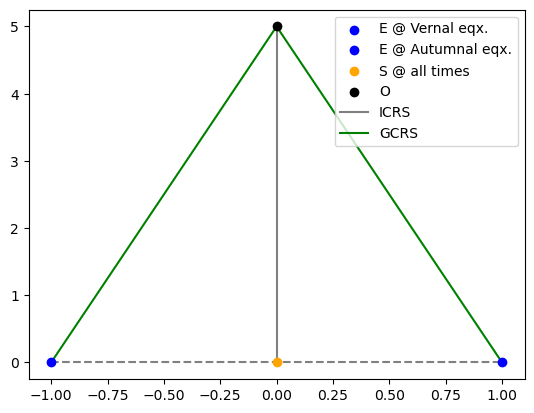

In [17]:
fig, ax = plt.subplots()

ax.scatter([-1, ], [0, ], color="blue", label="E @ Vernal eqx.")
ax.scatter([1, ], [0, ], color="blue", label="E @ Autumnal eqx.")
ax.scatter([0, ], [0, ], color="orange", label="S @ all times")
ax.scatter([0, ], [5, ], color="black", label="O")

ax.plot([0, 0], [0, 5], label="ICRS", color="gray", zorder=-1)
ax.plot([-1, 0], [0, 5], color="green", label="GCRS", zorder=-1, )
ax.plot([1, 0], [0, 5], color="green", zorder=-1)
ax.plot([-1, 1], [0, 0], color="gray", linestyle="--", zorder=-1)

plt.legend()

According to the internet:
* vernal equinox Mon, Mar 20, 2023 2:24 PM
* autumnal equinox Fri, Sep 22, 2023 11:49 PM 
    
This is the example above that we have set up. According to the sketch above, the angle at the object's vertex is expected to be

In [18]:
2*np.tan(1/distance.value) *u.rad.to(u.deg)*u.deg

<Quantity 2.29213681 deg>

In [19]:
print(
    "The angular distance between the ground truth converted to geocentric coordinates, including parallax:"
    f"is:\n {angular_separation(geo1.ra, geo1.dec, geo2.ra, geo2.dec).to(u.deg)}"
)

print(
    "The angular distance between the used observed geocentric coordinates:"
    f"is:\n {angular_separation(geo_observed1.ra, geo_observed1.dec, geo_observed2.ra, geo_observed2.dec).to(u.deg)}"
)
print(
    "The angular distance between the used observed heliocentric coordinates:"
    f"is:\n {angular_separation(icrs_observed1.ra, icrs_observed1.dec, icrs_observed2.ra, icrs_observed2.dec).to(u.deg)}"
)

The angular distance between the ground truth converted to geocentric coordinates, including parallax:is:
 2.291447261557424 deg
The angular distance between the used observed geocentric coordinates:is:
 2.291447261557424 deg
The angular distance between the used observed heliocentric coordinates:is:
 2.291446342062644 deg


So our setup is seems consistent. By extension if we can round-trip this calculation then it would mean that the implementation is correct. 

However, as we've seen with the `correct_parallax1` - the calculation isn't quite a full roundtrip, missing by ~3 arcseconds. I think that that's because the setup isn't perfectly correct and what we're really looking at is at an ever so slightly different scenario. 

The second human-understandable scenario worth considering is when the object is at an oblique angle to the radius vector Sun-Earth. The issue that appears then is that the object does not lie on the line-of-sight reported from the Sun (the ICRS coordinates). 

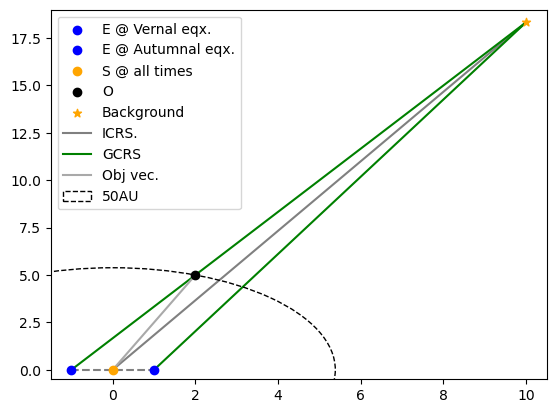

In [20]:
fig, ax = plt.subplots()

line  = lambda x: 5/3 * x + 5/3

ax.scatter([-1, ], [0, ], color="blue", label="E @ Vernal eqx.")
ax.scatter([1, ], [0, ], color="blue", label="E @ Autumnal eqx.")
ax.scatter([0, ], [0, ], color="orange", label="S @ all times")
ax.scatter([2, ], [5, ], color="black", label="O")
ax.scatter([10, ], [line(10), ], color="orange", marker="*", label="Background")

ax.plot([0, 10], [0, line(10)], label="ICRS.", color="gray", zorder=-1)
ax.plot([-1, 10], [0, line(10)], color="green", label="GCRS", zorder=-1)
ax.plot([1, 10], [0, line(10)], color="green", zorder=-1)
ax.plot([-1, 1], [0, 0], color="gray", linestyle="--", zorder=-1)

ax.plot([0, 2], [0, 5], label="Obj vec.", color="darkgray", zorder=-1)

circle1 = plt.Circle((0, 0), np.sqrt(2**2+5**2), fill=None, linestyle="--", label="50AU") 
ax.add_patch(circle1)

plt.xlim(-1.5, 10.5)
plt.ylim(-0.5, 19)

plt.legend()

In this case, we can't assume, as we did in the first case and in `correct_parallax1`, that heliocentric line of sight (LOS) at 50AU contains the object. In fact, in reality it is pointing in a completely different point in the solar system at that distance. 

In this situation, we are able to figure out the vector from the Sun to Earth, The LOS, i.e. unit vectors, from Sun to the Background stars (the given ICRS coordinates), the unit vector from Earth to the Background stars and we can say that the vector from the Sun to the Object has a length of 50 AU. 

The goal here is to return precisely that vector - the Sun to object - in terms of ICRS coordinates we then call "corrected for parallax". 

I believe the other `correct_parallax` functions address this situation: 
* `Using a point in sol sys` - returns exact, to float precission, solution but presents a weird behaviour. It requires us to specify a full point in the Solar System. It uses that point to calculate the LOS distance to Earth. That distance is then applied to the LOS to the LOS of the converted ICRS coordinate. The end result is that the coordinates of the given point change the point to which we convert the GCRS coordinate. The behaviour is unintuitive and strange
* `Minimization via guesses` and `Minimization via Scipy` are basically the same idea. There is some distance down the Earth-Object LOS, that when converted to ICRS will yield a vector with the given `guess_distance`. That vector is out solution. The only thing that is different between the two is how we guess that distance. The result returns easier to reason about values because it basically just directly returns the vector from that sketch, regardless of whether our pointing starts in the correct direction or not, kind of matching our definition of "corrected for parallax" the best.

Below we compare the behaviours of the functions for different distances, LOS and timestamps. The comparisons provide relative performance comparisons between different functions, not a guarantee of absolute precission. 

The absolute precission should be reconstructed from an historical measurement of exact position of Earth and imaginary object at different time-stamps in order to fully include all possible uncertainties in Earth's orbit and other effects as light-travel time, abberation etc.

In [305]:
def plot_summary(icrss, angsep, objdist, racat, deccat, distances): 
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(nrows=2, ncols=2)
    gs.update(wspace=0.35)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    for i, gd, hd, sep in zip(icrss, geodist, distances, angsep):
        ax1.scatter(i.ra, i.dec, label=f"{hd} AU")


    ax1.axvline(racat)
    ax1.axhline(deccat, label="Start position")
    ax1.set_title("ICRS of an initial position (blue cross) changes with parallax at a given distance and timestamp.")
    ax1.set_xlabel("Ra (deg)")
    ax1.set_ylabel("Dec (deg)")
    ax1.legend(ncol=4)
    
    tmpangs = np.array([i.arcsecond for i in angsep])
    ax2.plot(distances, tmpangs, marker="o", label="Angular separation")
    ax2.plot(distances, np.tan(1/distances) *u.rad.to(u.arcsec), label="tan(1/d)")
    ax2.set_xlabel("Distance (AU)")
    ax2.set_ylabel("Angular separation (arcsec)")
    ax2.set_yscale("log")
    ax2a = ax2.twinx()
    ax2a.plot(distances, np.abs(tmpangs-np.tan(1/distances)*u.rad.to(u.arcsec)), color="red", label="tan(1/d)-angsep")
    ax2a.set_ylabel("Calculated - tan(1/d) (arcseconds)")
    ax2.set_title("Angular separation between the start and end ICRS position.")
    ax2.legend()

    tmpgds = np.array([i.AU for i in objdist])
    ax3.set_title("Calulated vs Heliocentric Distance")
    ax3.plot(distances, tmpgds, marker="o",)
    ax3a = ax3.twinx()
    ax3a.plot(distances, tmpgds-distances, color="orange", label="calc-helio d")
    ax3.set_xlabel("Helio Distance (AU)")
    ax3.set_ylabel("Calc Distance (AU)")
    ax3a.set_ylabel("Calc-Helio Distance (AU)")
    ax3a.legend()
    
    return fig, [ax1, ax2, ax3, ax3a]
    
def correct_icrs_dists(distances, racat, deccat, corrective_f, **kwargs):
    icrss, angsep, objdist = [], [], []
    refpix_icrs = ICRS(ra=racat*u.deg, dec=deccat*u.deg)
    for d in distances:
        if "point_in_sol" in kwargs:
            ps = kwargs.pop("point_in_sol")
            point_in_sol = ICRS(ra=ps.ra, dec=ps.dec, distance=d*u.AU)
            kwargs["point_in_sol"] = point_in_sol
        corr_icrs = corrective_f(
            icrs=refpix_icrs, 
            point_on_earth=loc, 
            obstime=t1, 
            guess_distance=d,
            **kwargs
        )
        objdist.append(corr_icrs.distance)
        angsep.append(corr_icrs.separation(refpix_icrs))
        icrss.append(corr_icrs)
    
    return icrss, angsep, objdist

In [306]:
# This is our ground truth object
tgt_ra = 90 
tgt_dec = 0
guess_distance = 50 # *u.AU

# distances at which the ICRS correction will be evaluated
distances = np.array([
    *np.arange(10, 50, 3),
    *np.arange(50, 100, 15),
    *np.arange(100, 500, 100),
    *np.arange(500, 5000, 1000)
])


# The time of observation
t = Time(59945.0, format="mjd", scale="utc")

# the LOS of observation, as reported by FITS (so ICRS ra dec)
racat, deccat = 90, 0

The following plots show the following:
* in the top plot the calculated ICRS pointing corrected for the parallax. The expected behaviour is that the parallax starts far from the blue cross (the given ICRS coordinate) and converges to it as the distance increases and the parallax effect decreases
* in the bottom left plot the calculated angular separation of the given starting ICRS coordinate and the corrected ICRS coordinate. Plotted in orange is the expected parallax behaviour of the point. We expect good match between the two if the setup is correct, sometimes when setup is not correct there is an total offset in magnitude between the two. See the first sketched-out human-understandable scenario to see when you can expect the magnitude of the parallax to match the calculated one. In red, plotted is the difference between the theoretical 1/d and calculated angular separation. The scale of the difference is shown on the right-hand-side axis. Ideally the red line would be a horizontal line at 0, indicating that the theoretical parallax matches the calculated one at all points.
* In bottom right is the calculated versus guess distance. As long as that resembles a diagonal line all is well. In yellow is the difference between the two. The scale on the right-hand-side shows the magnitude of that difference in AU. Ideally the yellow line would be horizontal line at 0, indicating that assumed distance matches the calculated/fitted distance.


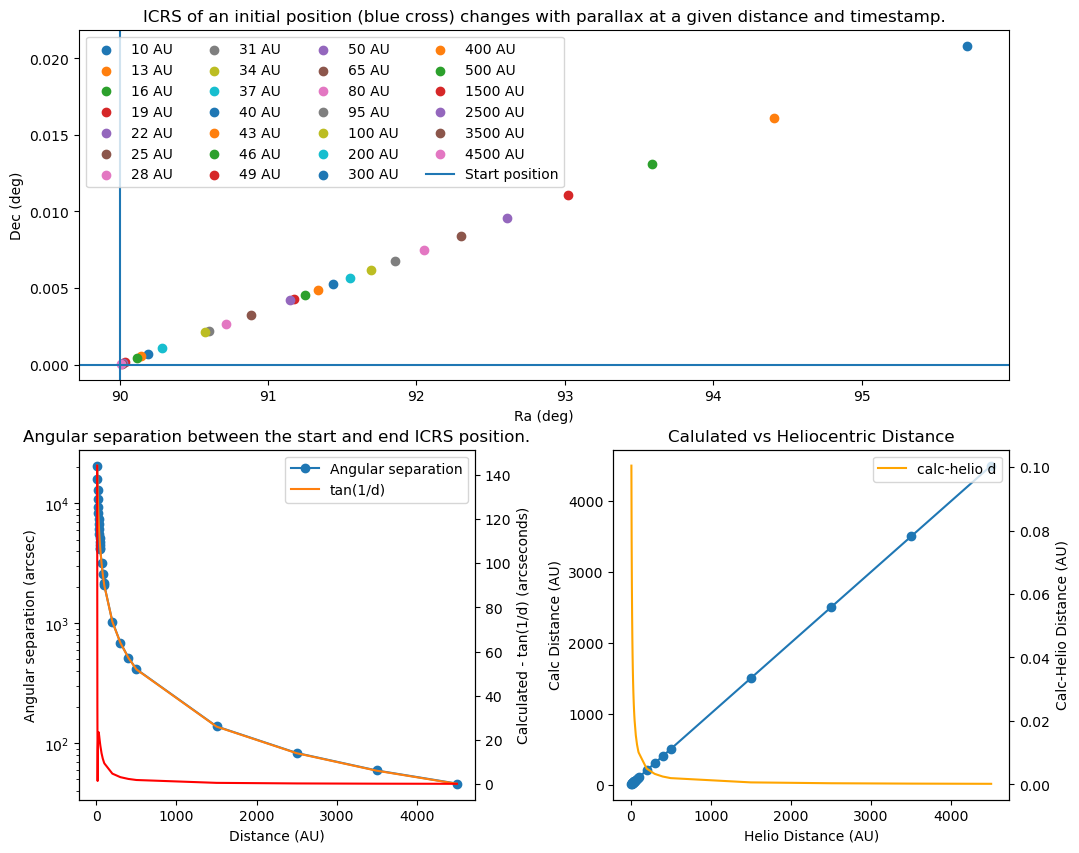

In [307]:
icrss1, angsep1, objdist1 = correct_icrs_dists(distances, racat, deccat, correct_parallax1)
_ = plot_summary(icrss1, angsep1, objdist1, racat, deccat, distances)

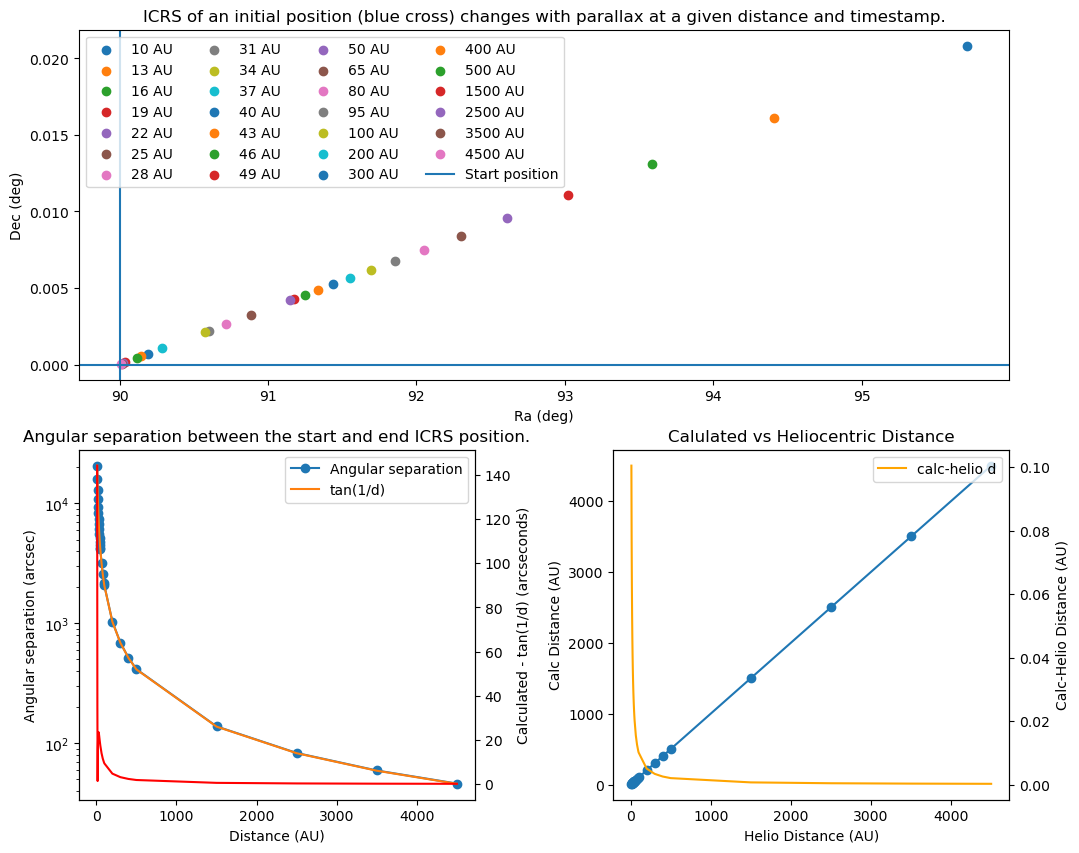

In [308]:
icrss2, angsep2, objdist2 = correct_icrs_dists(distances, racat, deccat, correct_parallax2, point_in_sol=point_in_sol)
_ = plot_summary(icrss2, angsep2, objdist2, racat, deccat, distances)

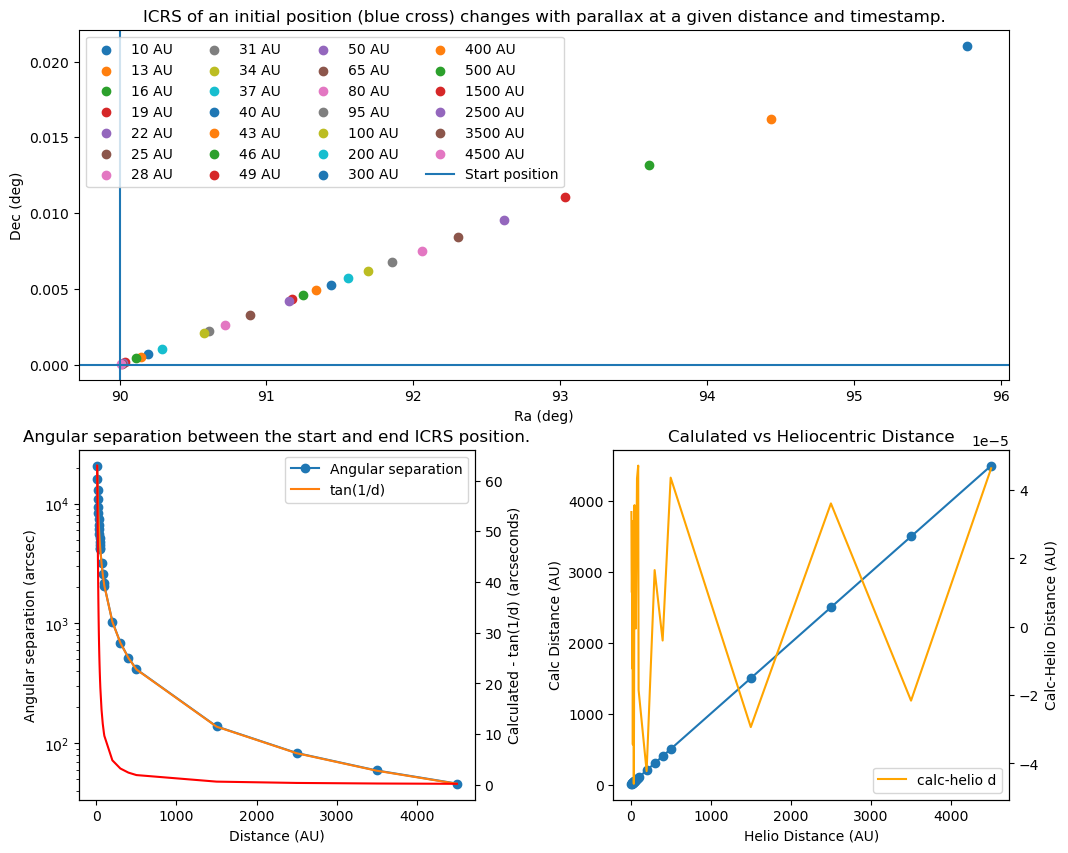

In [309]:
icrss3, angsep3, objdist3 = correct_icrs_dists(distances, racat, deccat, correct_parallax3)
_ = plot_summary(icrss3, angsep3, objdist3, racat, deccat, distances)

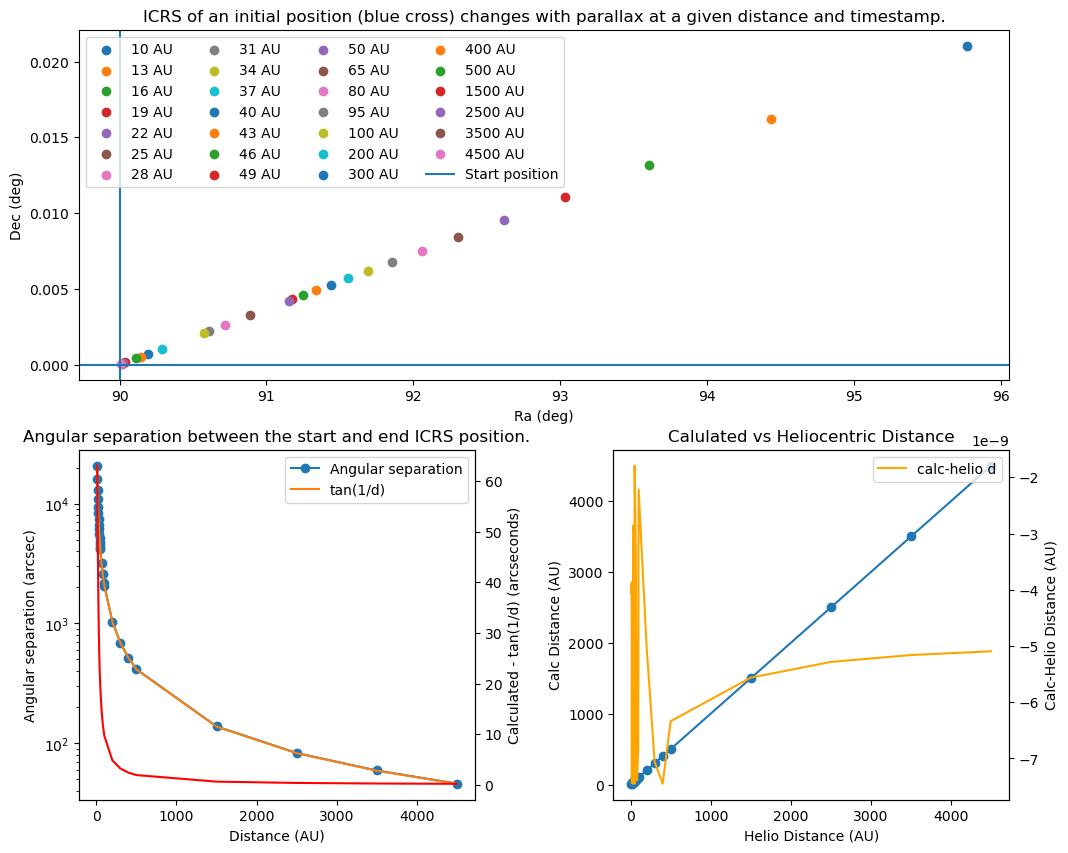

In [310]:
icrss4, angsep4, objdist4 = correct_icrs_dists(distances, racat, deccat, correct_parallax4)
_ = plot_summary(icrss4, angsep4, objdist4, racat, deccat, distances)

Ok, dense but as already mentioned, these plots don't really tell us much, except how well we roundtrip the calculation. 

Obviously, the behaviour of all of the points on the sky is seemingly the same or at least similar. Differences on the order of couple to 10s of arcsecond won't be visible on a plt spanning more than 5 degrees on the sky. We are getting progressively better and better in our estimates of the distances however, from half an arcsecond error to 10-9 arcseconds error.

The behaviour of the parallax behaves the same for all of them and the on-sky look of the parallax is about the same. 

Following are relative errors between the methods. Note that because of the distance sampling methodology the x axis of the plots does not follow a linear scaling. It is instead evenly-spaced per distance sample. To see a more representative scaling of estimated versus see the above plots.

In [257]:
d1 = np.array([i.AU for i in objdist1])
a1 = np.array([i.arcsec for i in angsep1])

d2 = np.array([i.AU for i in objdist2])
a2 = np.array([i.arcsec for i in angsep2])

d3 = np.array([i.AU for i in objdist3])
a3 = np.array([i.arcsec for i in angsep3])

d4 = np.array([i.AU for i in objdist4])
a4 = np.array([i.arcsec for i in angsep4])

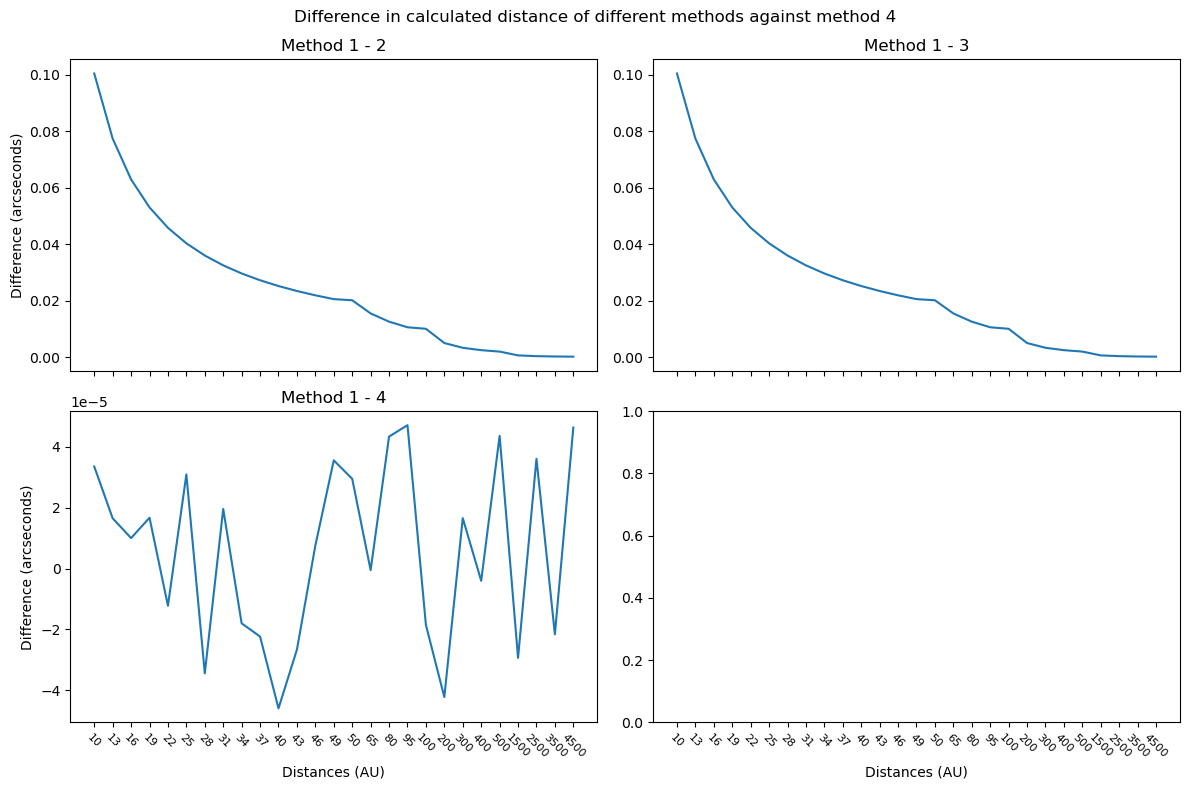

In [258]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)


ax[0,0].plot(d1-d4, label="1 - 2")
ax[0,0].set_title("Method 1 - 2")
ax[0,0].set_ylabel("Difference (arcseconds)")
ax[0,1].plot(d2-d4, label="1 - 3")
ax[0,1].set_title("Method 1 - 3")
ax[1,0].plot(d3-d4, label="1-4")
ax[1,0].set_ylabel("Difference (arcseconds)")
ax[1,0].set_title("Method 1 - 4")
ax[1,0].set_xlabel("Distances (AU)")
ax[1,1].set_xlabel("Distances (AU)")

idx = range(len(distances))
for a in ax.ravel():
    a.set_xticks(range(len(distances)))
    a.set_xticklabels(distances, fontsize=8, rotation=-45)


_ = fig.suptitle("Difference in calculated distance of different methods against method 4")
plt.tight_layout()

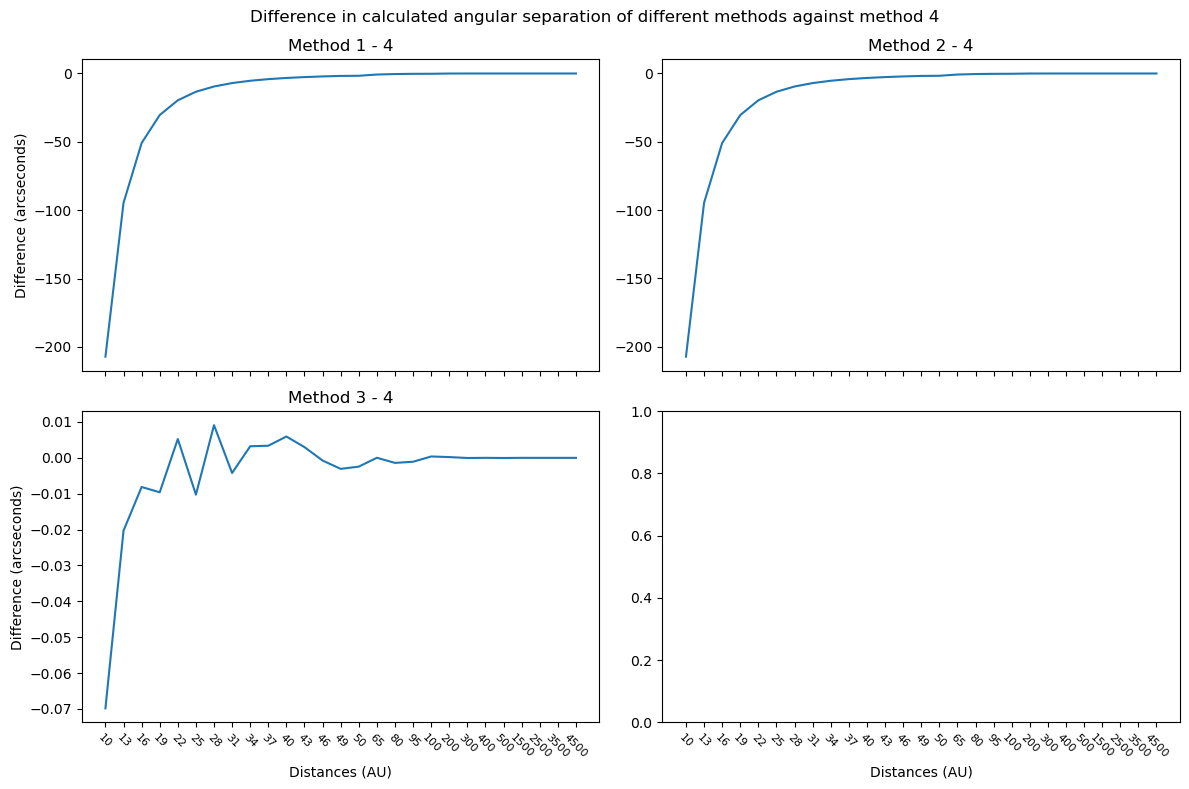

In [259]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

ax[0,0].plot(a1-a4, label="1 - 4")
ax[0,0].set_title("Method 1 - 4")
ax[0,0].set_ylabel("Difference (arcseconds)")
ax[0,1].plot(a2-a4, label="2 - 4")
ax[0,1].set_title("Method 2 - 4")
ax[1,0].plot(a3-a4, label="3-4")
ax[1,0].set_title("Method 3 - 4")
ax[1,0].set_ylabel("Difference (arcseconds)")
ax[1,0].set_xlabel("Distances (AU)")
ax[1,1].set_xlabel("Distances (AU)")

idx = range(len(distances))
for a in ax.ravel():
    a.set_xticks(range(len(distances)))
    a.set_xticklabels(distances, fontsize=8, rotation=-45)

_ = fig.suptitle("Difference in calculated angular separation of different methods against method 4")
plt.tight_layout()

# Notes on the AstroPy coordinates strangeness

Notably important is the AstroPy quirk where in the transformations some values are inheritted from the right hand side (target) coordinate system, namely time stamp. However, the parallax is not applied unless the distance has been specified on the left-hand side (source) coordinate system. This is quite confusing, see examples below.

In [317]:
# No parallax applied, expected
ICRS(
    ra=ra,
    dec=dec,
).transform_to(GeocentricTrueEcliptic())

<GeocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=J2000.000): (lon, lat, distance) in (deg, deg, )
    (90.00182448, 0.00024423, 1.)>

In [318]:
# parallax applied, expected
ICRS(
    ra=ra,
    dec=dec,
    distance=distance
).transform_to(GeocentricTrueEcliptic())

<GeocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=J2000.000): (lon, lat, distance) in (deg, deg, AU)
    (89.78650875, 1.27517046e-05, 49.03590027)>

In [321]:
# a third value? But no distance is given - so it's not parallax
# OBSTIME changed - so earth is not assumed to be in J2000 timestamp position
# but at at the position of the given timestamp
# ok, good, albeit not imediately obvious 
ICRS(
    ra=ra,
    dec=dec,
).transform_to(GeocentricTrueEcliptic(obstime=t1))

<GeocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=2023-03-20T16:00:00.000): (lon, lat, distance) in (deg, deg, )
    (89.99627916, 0.00024441, 1.)>

In [323]:
# so if the Geocentric is given a distance, why does it return
# the same as above. The above had a time, and that correctly applied
# to the position of the earth, but if I give a distance and a time
# the time applies but distance doesn't? 
# Even if I correctly accounted for the fact it's an LOS distance from Earth.
# This is strange.
ICRS(
    ra=ra,
    dec=dec,
).transform_to(
    GeocentricTrueEcliptic(
        lon=0*u.deg,
        lat=0*u.deg,
        obstime=t1,
        distance=50.002*u.AU
    )
)

<GeocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=2023-03-20T16:00:00.000): (lon, lat, distance) in (deg, deg, )
    (89.99627916, 0.00024441, 1.)>

In [325]:
# Only now is both the position of Earth and the 
# parallax due to the distance of the object from the Sun
# correctly applied. This is the 4th possible value.
ICRS(
    ra=ra,
    dec=dec,
    distance=50*u.AU
).transform_to(
    GeocentricTrueEcliptic(
        obstime=t1,
    )
)

<GeocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=2023-03-20T16:00:00.000): (lon, lat, distance) in (deg, deg, AU)
    (88.84480468, -7.98090831e-06, 50.00131398)>

In [340]:
# So what happens in cases when boths sides have distance and time?
# (ICRS has no way to specify time)
# The timestamp t2 is inherited but distance is not!
# (if it were we would be expecting distance of 148AU)
HeliocentricTrueEcliptic(
    lon=0*u.deg,
    lat=0*u.deg,
    distance=50*u.AU,
    obstime=t1
).transform_to(
    GeocentricTrueEcliptic(
        lon=0*u.deg,
        lat=0*u.deg,
        obstime=t2,
        distance=150.02*u.AU
    )
)

# t1 = <Time object: scale='utc' format='isot' value=2023-03-20T16:00:00.000>
# t2 =  <Time object: scale='utc' format='isot' value=2023-09-24T04:00:00.000>

<GeocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=2023-09-24T04:00:00.000): (lon, lat, distance) in (deg, deg, AU)
    (359.9965286, 4.34155512e-06, 48.99615704)>

Is it safe to start from ICRS, transform to heliocentric or geocentric and expect the parallax to correctly be applied? 

Given that for our particular setup we know that we are expecting the position of the stationary object in ICRS to be `(90, 23.44)` (i.e. approximately the helio longitude and the Earth's inclinaton) do we recover the `HeliocentricEcliptic` coordinates we started from?

In [311]:
dpix = ICRS(ra=90.01538407*u.deg, dec=23.43952481*u.deg, distance=50*u.AU)

pixhel1 = dpix.transform_to(HeliocentricTrueEcliptic(obstime=t1))
pixhel2 = dpix.transform_to(HeliocentricTrueEcliptic(obstime=t2))

print(pixhel1)
print(pixhel2)

<HeliocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=2023-03-20T16:00:00.000): (lon, lat, distance) in (deg, deg, AU)
    (90.00000012, 4.73585395e-09, 50.00060115)>
<HeliocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=2023-09-24T04:00:00.000): (lon, lat, distance) in (deg, deg, AU)
    (90.00061383, -7.87438e-07, 50.00216322)>


Yes, ergo we can believe that the parallax is correctly applied, alongside with a new calculated Heliocentric distance - as the Sun has travelled around the barycenter during the 6 months period.

This is valid as long as all parallax related information lives in the source coordinate object, and obstime related content in either of the source or target object.